In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky, search_around_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng
import astropy.cosmology

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import random_utils

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

## Load in data

In [4]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [7]:
G_max = 20
fn_gaia = f'../data/gaia_G{G_max}.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [8]:
tab_gaia.columns

<TableColumns names=('ra','dec','redshift_qsoc','l','b','source_id','phot_g_mean_mag','phot_bp_mean_mag','phot_rp_mean_mag','redshift_qsoc_lower','redshift_qsoc_upper','zscore_qsoc','flags_qsoc','allwise_oid','w1mpro','w2mpro','g_rp','bp_g','bp_rp','g_w1','w1_w2','ebv','A_v','redshift_spz','redshift_sdss')>

In [9]:
cosmo = astropy.cosmology.Planck15
dist = (cosmo.comoving_distance(tab_gaia['redshift_spz'])*cosmo.h).value # convert to Mpc/h

In [10]:
x, y, z = utils.radec_to_cartesian(dist, ra_data, dec_data)

# Load in randoms

In [11]:
fn_stardust = '../data/randoms/random_stardust64_10x.fits'
tab_stardust = utils.load_table(fn_stardust)

In [12]:
ra_stardust, dec_stardust = tab_stardust['ra'], tab_stardust['dec']

Commented out bc now doing redshift assignment after masking, to make sure to only mix up the redshifts in use

In [11]:
# assign random distances from data
#dist_stardust = rng.choice(dist, replace=True, size=len(tab_stardust))

In [12]:
#x_stardust, y_stardust, z_stardust = utils.radec_to_cartesian(dist_stardust, ra_stardust, dec_stardust)

# Vary plane masking

In [13]:
col_names = ['maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']
rand_configs_stardust = [[False, False, False, None, None, 64],
                         [False, True, False, None, None, 64],
                         [True, True, False, 10, None, 64],
                         [True, True, False, 20, None, 64],
                         [True, True, False, 30, None, 64],
                       ] 
df_rconfigs_stardust = pd.DataFrame(data = rand_configs_stardust, 
                                    columns = col_names)

In [14]:
idx_arrs_masks_data, idx_arrs_masks_rand = random_utils.get_idx_arrs_masked(df_rconfigs_stardust, 
                                                                            ra_stardust, dec_stardust, 
                                                                            ra_data, dec_data)

Applied mask, kept 0.998 of sources
Applied mask, kept 0.997 of sources
Masking galactic plane to b=10.0
Applied mask, kept 0.981 of sources
Applied mask, kept 0.998 of sources
Masking galactic plane to b=10.0
Applied mask, kept 0.988 of sources
Applied mask, kept 0.997 of sources
Masking galactic plane to b=20.0
Applied mask, kept 0.869 of sources
Applied mask, kept 0.998 of sources
Masking galactic plane to b=20.0
Applied mask, kept 0.892 of sources
Applied mask, kept 0.997 of sources
Masking galactic plane to b=30.0
Applied mask, kept 0.703 of sources
Applied mask, kept 0.998 of sources
Masking galactic plane to b=30.0
Applied mask, kept 0.727 of sources
Applied mask, kept 0.997 of sources


In [15]:
len(df_rconfigs_stardust), len(idx_arrs_masks_data)

(5, 5)

# CF

In [5]:
nthreads = 4
rmin, rmax = 24, 176
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [27]:
r_edges

array([ 24,  32,  40,  48,  56,  64,  72,  80,  88,  96, 104, 112, 120,
       128, 136, 144, 152, 160, 168, 176])

In [28]:
xis_stardust = []
for i in range(len(df_rconfigs_stardust)):
    idx_data, idx_rand = idx_arrs_masks_data[i], idx_arrs_masks_rand[i]
    
    # only choose distances from unmasked areas
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, ra_stardust[idx_rand], dec_stardust[idx_rand])
    
    xis_stardust.append( correlations.compute_xi(r_edges, x[idx_data], y[idx_data], z[idx_data], 
                                                          x_rand, y_rand, z_rand) )

Time: 1.1202 s
Time: 16.5241 s
Time: 71.3704 s

Time: 1.1140 s
Time: 16.4801 s
Time: 71.1556 s

Time: 1.1058 s
Time: 16.2336 s
Time: 70.0022 s

Time: 1.0135 s
Time: 14.7328 s
Time: 63.1260 s

Time: 0.8304 s
Time: 12.0894 s
Time: 51.8310 s



In [30]:
for i in range(len(df_rconfigs_stardust)):
    n_data = np.sum(idx_arrs_masks_data[i])
    n_rand = np.sum(idx_arrs_masks_rand[i])
    print(n_data, n_rand)

648842 6495758
646798 6479921
639165 6353330
576889 5626755
469689 4550662


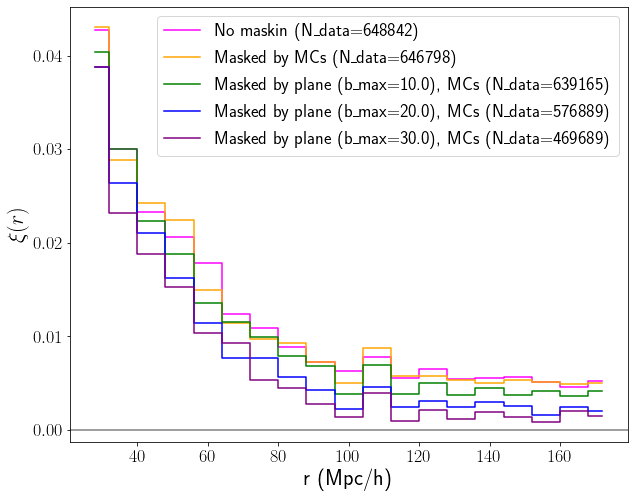

In [29]:
colors = ['magenta', 'orange', 'green', 'blue', 'purple']
plt.figure(figsize=(10,8))
for i in range(len(df_rconfigs_stardust)):
    n_data = np.sum(idx_arrs_masks_data[i])
    plt.step(r_avg, xis_stardust[i], where='mid', color=colors[i], 
             label=df_rconfigs_stardust['mask_title'][i]+f' (N_data={n_data})')

plt.xlabel('r (Mpc/h)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

# Dust masking

In [4]:
col_names = ['maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']
rand_configs_Av = [[False, False, False, None, None, 64],
                         [False, True, False, None, None, 64],
                         [False, True, True, None, 0.2, 64],
                         [False, True, True, None, 0.35, 64],
                         [False, True, True, None, 0.5, 64],
                       ] 
df_rconfigs_Av = pd.DataFrame(data = rand_configs_Av, 
                                    columns = col_names)

In [13]:
idx_arrs_masks_data_Av, idx_arrs_masks_rand_Av = random_utils.get_idx_arrs_masked(df_rconfigs_Av, 
                                                                            ra_stardust, dec_stardust, 
                                                                            ra_data, dec_data)

Applied mask, kept 0.998 of sources
Applied mask, kept 0.997 of sources
Applied mask, kept 0.998 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Generating new dust map (../data/dustmap_Avmean_NSIDE64.npy
NPIX for dust map sampling: 50331648
Saved dust map to ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.686 of sources
Applied mask, kept 0.997 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.708 of sources
Applied mask, kept 0.998 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.862 of sources
Applied mask, kept 0.997 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy
Applied mask, kept 0.879 of sources
Applied mask, kept 0.998 of sources
64 3.1 ../data/dustmap_Avmean_NSIDE64.npy
Dustmap already exists, load

In [16]:
xis_Av = []
for i in range(len(df_rconfigs_Av)):
    idx_data, idx_rand = idx_arrs_masks_data_Av[i], idx_arrs_masks_rand_Av[i]
    
    # only choose distances from unmasked areas
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, ra_stardust[idx_rand], dec_stardust[idx_rand])
    
    xis_Av.append( correlations.compute_xi(r_edges, x[idx_data], y[idx_data], z[idx_data], 
                                                          x_rand, y_rand, z_rand) )

[Warning] The CPU supports AVX512F but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


Time: 1.3695 s
Time: 17.5418 s
Time: 72.2862 s

Time: 1.1271 s
Time: 17.4328 s
Time: 72.0799 s

Time: 0.8076 s
Time: 12.0762 s
Time: 49.5281 s

Time: 0.9922 s
Time: 15.2882 s
Time: 62.8439 s

Time: 1.0528 s
Time: 16.3885 s
Time: 67.5654 s



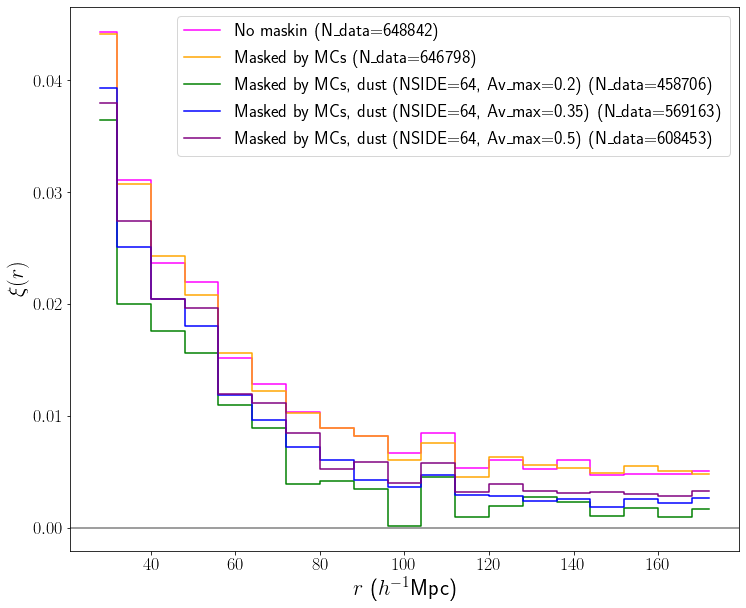

In [21]:
colors = ['magenta', 'orange', 'green', 'blue', 'purple']
plt.figure(figsize=(12,10))
# little hack bc want to reorder legend in plot
#i_order = [0, 1, 4, 3, 2]
#for i in i_order:
for i in range(len(df_rconfigs_Av)):
    n_data = np.sum(idx_arrs_masks_data_Av[i])
    plt.step(r_avg, xis_Av[i], where='mid', color=colors[i], 
             label=df_rconfigs_Av['mask_title'][i]+f' (N_data={n_data})')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

## G=20.4

In [5]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [6]:
G_max = 20.4
fn_gaia_G204 = f'../data/gaia_G{G_max}.fits'
tab_gaia_G204 = utils.load_table(fn_gaia_G204)
N_data_G204 = len(tab_gaia_G204)
ra_data_G204, dec_data_G204 = tab_gaia_G204['ra'], tab_gaia_G204['dec']
print(f"Number of data sources: {N_data_G204}")

Number of data sources: 1001557


In [7]:
cosmo = astropy.cosmology.Planck15
dist = (cosmo.comoving_distance(tab_gaia_G204['redshift_spz'])*cosmo.h).value # convert to Mpc/h

In [8]:
x_G204, y_G204, z_G204 = utils.radec_to_cartesian(dist, ra_data_G204, dec_data_G204)

## Load in randoms

In [11]:
fn_stardustm10 = f'../data/randoms/random_stardustm1064_G{G_max}_10x.fits'
tab_stardustm10 = utils.load_table(fn_stardustm10)

In [12]:
ra_stardustm10, dec_stardustm10 = tab_stardustm10['ra'], tab_stardustm10['dec']

## Varying masks

In [14]:
col_names = ['maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']
rand_configs_stardustm10 = [[False, False, False, None, None, 64],
                         [False, True, False, None, None, 64],
                         [False, True, True, None, 0.3, 64],
                         #[True, True, False, 20, None, 64],
                         #[True, True, False, 30, None, 64],
                       ] 
df_rconfigs_stardustm10 = pd.DataFrame(data = rand_configs_stardustm10, 
                                    columns = col_names)

In [19]:
idx_arrs_masks_data_G204, idx_arrs_masks_rand_G204 = random_utils.get_idx_arrs_masked(df_rconfigs_stardustm10, 
                                                                            ra_stardustm10, dec_stardustm10, 
                                                                            ra_data_G204, dec_data_G204)

Applied mask, kept 0.998 of sources
Applied mask, kept 0.997 of sources
Applied mask, kept 0.998 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.837 of sources
Applied mask, kept 0.997 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.842 of sources


In [18]:
nthreads = 4
rmin, rmax = 24, 176
bin_size = 8
r_edges = np.arange(rmin, rmax+bin_size, bin_size)
r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

In [21]:
xis_G204 = []
for i in range(len(df_rconfigs_stardustm10)):
    idx_data, idx_rand = idx_arrs_masks_data_G204[i], idx_arrs_masks_rand_G204[i]
    
    # only choose distances from unmasked areas
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, ra_stardustm10[idx_rand], dec_stardustm10[idx_rand])
    
    xis_G204.append( correlations.compute_xi(r_edges, x_G204[idx_data], y_G204[idx_data], z_G204[idx_data], 
                                                          x_rand, y_rand, z_rand) )

[Warning] The CPU supports AVX512F but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


Time: 2.2778 s
Time: 34.9961 s
Time: 155.8936 s

Time: 2.1215 s
Time: 34.9183 s
Time: 164.6128 s

Time: 2.0894 s
Time: 33.4315 s
Time: 140.0657 s



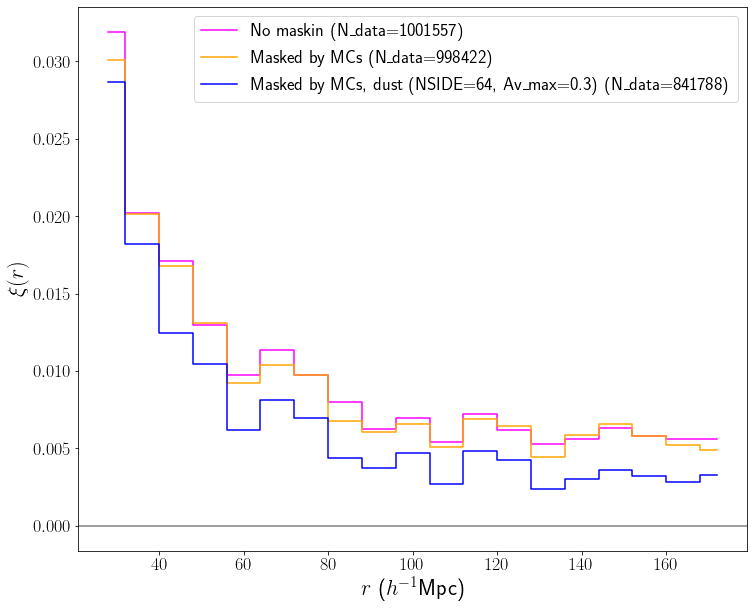

In [24]:
colors = ['magenta', 'orange', 'blue']
plt.figure(figsize=(12,10))
# little hack bc want to reorder legend in plot
#i_order = [0, 1, 4, 3, 2]
#for i in i_order:
for i in range(len(df_rconfigs_stardustm10)):
    n_data = np.sum(idx_arrs_masks_data_G204[i])
    plt.step(r_avg, xis_G204[i], where='mid', color=colors[i], 
             label=df_rconfigs_stardustm10['mask_title'][i]+f' (N_data={n_data})')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

# G variation

In [6]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [7]:
G_maxs = [20, 20.2, 20.4]

In [8]:
pos_G = []
radec_G = []
dist_G = []
for G_max in G_maxs:
    fn_gaia_G = f'../data/gaia_G{G_max}.fits'
    tab_gaia_G = utils.load_table(fn_gaia_G)
    N_data_G = len(tab_gaia_G)
    ra_data_G, dec_data_G = tab_gaia_G['ra'], tab_gaia_G['dec']
    print(f"Number of data sources: {N_data_G}")
    radec_G.append(np.array([ra_data_G, dec_data_G]))
    
    cosmo = astropy.cosmology.Planck15
    dist = (cosmo.comoving_distance(tab_gaia_G['redshift_spz'])*cosmo.h).value # convert to Mpc/h
    dist_G.append(dist)
    x_G, y_G, z_G = utils.radec_to_cartesian(dist, ra_data_G, dec_data_G)
    pos_G.append(np.array([x_G, y_G, z_G]))
print("done!")

Number of data sources: 648842
Number of data sources: 812375
Number of data sources: 1001557
done!


## Load in randoms

In [9]:
col_names = ['maskplane', 'maskmcs', 'maskdust', 'b_max', 'Av_max', 'NSIDE_dustmap']

In [ ]:
xis_G = []
idx_data_G = []
idx_rand_G = []
for gg, G_max in enumerate(G_maxs):
    fn_stardustm10_G = f'../data/randoms/random_stardustm1064_G{G_max}_10x.fits'
    tab_stardustm10_G = utils.load_table(fn_stardustm10_G)
    ra_stardustm10_G, dec_stardustm10_G = tab_stardustm10_G['ra'], tab_stardustm10_G['dec']
    
    rand_configs_stardustm10_G = [[False, False, False, None, None, 64],
                         #[False, True, False, None, None, 64],
                         #[False, True, True, None, 0.3, 64],
                         #[True, True, False, 20, None, 64],
                         #[True, True, False, 30, None, 64],
                       ] 
    df_rconfigs_stardustm10_G = pd.DataFrame(data = rand_configs_stardustm10_G, 
                                        columns = col_names)

    ra_data_G, dec_data_G = radec_G[gg]
    idx_arrs_masks_data_G, idx_arrs_masks_rand_G = random_utils.get_idx_arrs_masked(df_rconfigs_stardustm10_G, 
                                                                                ra_stardustm10_G, dec_stardustm10_G, 
                                                                                ra_data_G, dec_data_G)
    
    # assume only 1 row for now
    idx_data = idx_arrs_masks_data_G[0]
    idx_rand = idx_arrs_masks_rand_G[0]
    idx_data_G.append(idx_data)
    idx_rand_G.append(idx_rand)
    
    dist = dist_G[gg]
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, 
                                                      ra_stardustm10_G[idx_rand], dec_stardustm10_G[idx_rand])
    
    x_G, y_G, z_G = pos_G[gg]
    xis_G.append( correlations.compute_xi(r_edges, x_G[idx_data], y_G[idx_data], z_G[idx_data], 
                                                          x_rand, y_rand, z_rand) )

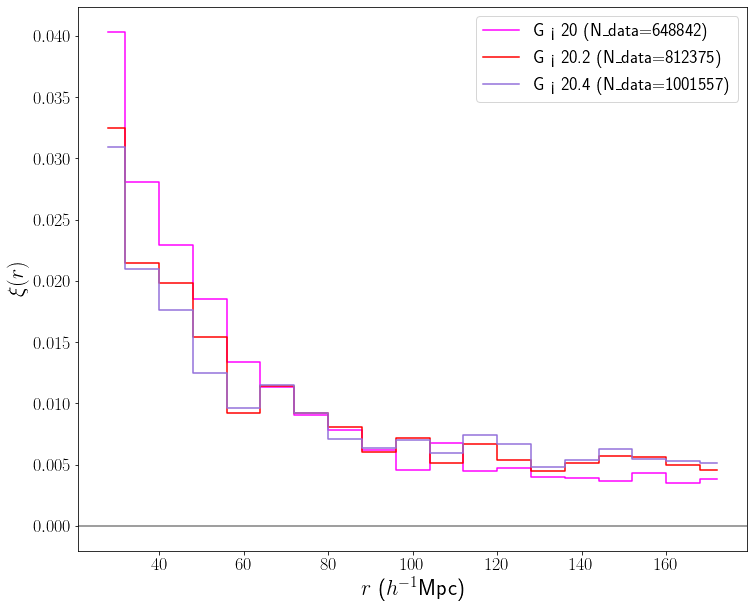

In [49]:
colors = ['magenta', 'red', 'mediumpurple']
plt.figure(figsize=(12,10))
for i in range(len(xis_G)):
    title = rf'G < {G_maxs[i]}'
    n_data = np.sum(idx_data_G[i])
    plt.step(r_avg, xis_G[i], where='mid', color=colors[i], 
             label=title+f' (N_data={n_data})')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

## With  (MCs + aggressive dust)

In [10]:
idx_data_G = []
idx_rand_G = []
radec_rand_G = []
for gg, G_max in enumerate(G_maxs):
    fn_stardustm10_G = f'../data/randoms/random_stardustm1064_G{G_max}_10x.fits'
    tab_stardustm10_G = utils.load_table(fn_stardustm10_G)
    ra_stardustm10_G, dec_stardustm10_G = tab_stardustm10_G['ra'], tab_stardustm10_G['dec']
    radec_rand_G.append(np.array([ra_stardustm10_G, dec_stardustm10_G]))
    
    rand_configs_stardustm10_G = [[False, True, True, None, 0.2, 64],
                       ] 
    df_rconfigs_stardustm10_G = pd.DataFrame(data = rand_configs_stardustm10_G, 
                                        columns = col_names)

    ra_data_G, dec_data_G = radec_G[gg]
    idx_arrs_masks_data_G, idx_arrs_masks_rand_G = random_utils.get_idx_arrs_masked(df_rconfigs_stardustm10_G, 
                                                                                ra_stardustm10_G, dec_stardustm10_G, 
                                                                                ra_data_G, dec_data_G)
    # assume only 1 row for now
    idx_data_G.append(idx_arrs_masks_data_G[0])
    idx_rand_G.append(idx_arrs_masks_rand_G[0])

Applied mask, kept 0.998 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.699 of sources
Applied mask, kept 0.997 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.708 of sources
Applied mask, kept 0.998 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.700 of sources
Applied mask, kept 0.997 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.708 of sources
Applied mask, kept 0.998 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy
Applied mask, kept 0.703 of sources
Applied mask, kept 0.997 of sources
64 3.1 ../data/maps/map_dust_NSIDE64.npy
Dus

In [55]:
xis_G = []
for gg, G_max in enumerate(G_maxs):
    idx_data = idx_data_G[gg]
    idx_rand = idx_rand_G[gg]
    dist = dist_G[gg]
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    
    ra_rand_G, dec_rand_G = radec_rand_G[gg]
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, 
                                                      ra_rand_G[idx_rand], dec_rand_G[idx_rand])
    
    x_G, y_G, z_G = pos_G[gg]
    xis_G.append( correlations.compute_xi(r_edges, x_G[idx_data], y_G[idx_data], z_G[idx_data], 
                                                          x_rand, y_rand, z_rand) )

Time: 0.7869 s
Time: 11.7221 s
Time: 50.5386 s

Time: 1.0932 s
Time: 17.0260 s
Time: 74.3769 s

Time: 1.5322 s
Time: 24.7395 s
Time: 110.2173 s



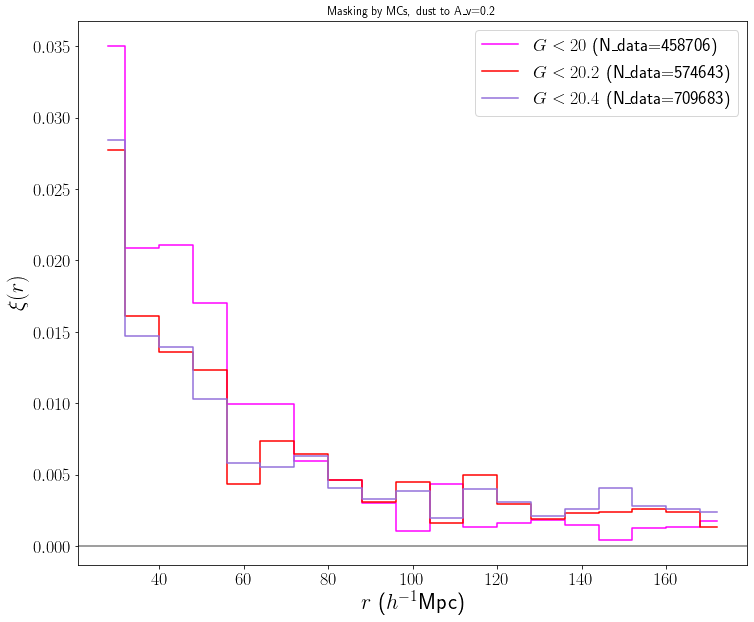

In [58]:
colors = ['magenta', 'red', 'mediumpurple']
plt.figure(figsize=(12,10))
plt.title('Masking by MCs, dust to A_v=0.2')
for i in range(len(xis_G)):
    title = rf'$G < {G_maxs[i]}$'
    n_data = np.sum(idx_data_G[i])
    plt.step(r_avg, xis_G[i], where='mid', color=colors[i], 
             label=title+f' (N_data={n_data})')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

# Messing with bins

### Changing bin size

In [59]:
nthreads = 4
rmin, rmax = 24, 176

In [60]:
bin_sizes = [2,4,8]
gg = 0

xis_binsize = []
for bb, bin_size in enumerate(bin_sizes):
    
    r_edges = np.arange(rmin, rmax+bin_size, bin_size)
    r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

    idx_data = idx_data_G[gg]
    idx_rand = idx_rand_G[gg]
    dist = dist_G[gg]
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    
    ra_rand_G, dec_rand_G = radec_rand_G[gg]
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, 
                                                      ra_rand_G[idx_rand], dec_rand_G[idx_rand])
    
    x_G, y_G, z_G = pos_G[gg]
    xis_binsize.append( correlations.compute_xi(r_edges, x_G[idx_data], y_G[idx_data], z_G[idx_data], 
                                                          x_rand, y_rand, z_rand) )

Time: 0.9228 s
Time: 14.0753 s
Time: 62.3939 s

Time: 0.8520 s
Time: 12.8313 s
Time: 56.3278 s

Time: 0.7934 s
Time: 11.7413 s
Time: 50.5844 s



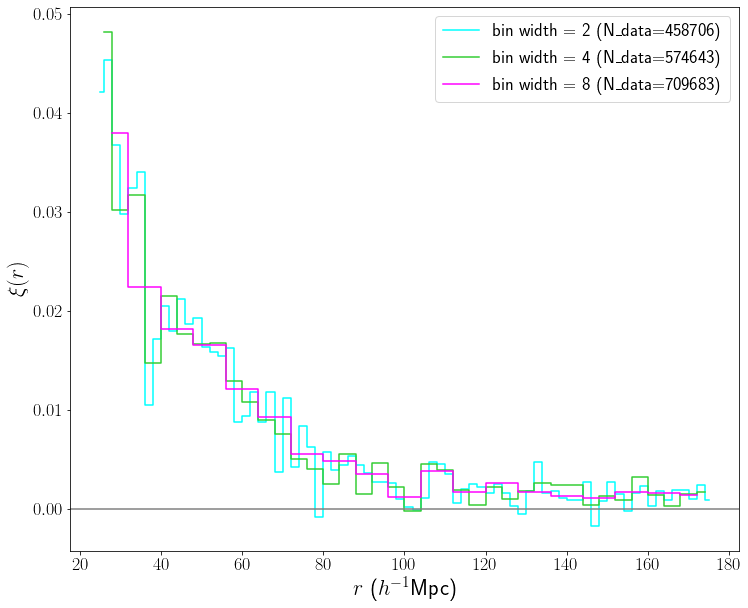

In [64]:
colors = ['cyan', 'limegreen', 'magenta']
plt.figure(figsize=(12,10))
for bb, bin_size in enumerate(bin_sizes):
    
    r_edges = np.arange(rmin, rmax+bin_size, bin_size)
    r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])    
    title = f'bin width = {bin_size}'
    n_data = np.sum(idx_data_G[gg])
    plt.step(r_avg, xis_binsize[bb], where='mid', color=colors[bb], 
             label=title+f' (N_data={n_data})')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()

### Multiple phasings

In [11]:
nthreads = 4
rmin, rmax = 24, 176
phase_size = 2
bin_size = 8

In [12]:
gg = 0

xis_phase = []
for pp in range(int(bin_size/phase_size)):
    rmin_p = rmin + phase_size*pp
    rmax_p = rmax + phase_size*pp
    
    r_edges = np.arange(rmin_p, rmax_p+bin_size, bin_size)
    print(r_edges)
    r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])

    idx_data = idx_data_G[gg]
    idx_rand = idx_rand_G[gg]
    dist = dist_G[gg]
    dist_rand = rng.choice(dist[idx_data], replace=True, size=np.sum(idx_rand))
    
    ra_rand_G, dec_rand_G = radec_rand_G[gg]
    x_rand, y_rand, z_rand = utils.radec_to_cartesian(dist_rand, 
                                                      ra_rand_G[idx_rand], dec_rand_G[idx_rand])
    
    x_G, y_G, z_G = pos_G[gg]
    xis_phase.append( correlations.compute_xi(r_edges, x_G[idx_data], y_G[idx_data], z_G[idx_data], 
                                                          x_rand, y_rand, z_rand) )

[ 24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144 152 160
 168 176]


[Warning] The CPU supports AVX512F but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports AVX but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.2 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSE4.1 but the compiler does not.  Can you try another compiler?
[Warning] The CPU supports SSSE3 but the compiler does not.  Can you try another compiler?


Time: 0.7889 s
Time: 11.7341 s
Time: 50.0734 s

[ 26  34  42  50  58  66  74  82  90  98 106 114 122 130 138 146 154 162
 170 178]
Time: 0.8078 s
Time: 11.6844 s
Time: 51.6850 s

[ 28  36  44  52  60  68  76  84  92 100 108 116 124 132 140 148 156 164
 172 180]
Time: 0.8234 s
Time: 11.9647 s
Time: 53.2111 s

[ 30  38  46  54  62  70  78  86  94 102 110 118 126 134 142 150 158 166
 174 182]
Time: 0.8377 s
Time: 12.3640 s
Time: 55.2546 s



[ 24  32  40  48  56  64  72  80  88  96 104 112 120 128 136 144 152 160
 168 176]
[ 26  34  42  50  58  66  74  82  90  98 106 114 122 130 138 146 154 162
 170 178]
[ 28  36  44  52  60  68  76  84  92 100 108 116 124 132 140 148 156 164
 172 180]
[ 30  38  46  54  62  70  78  86  94 102 110 118 126 134 142 150 158 166
 174 182]


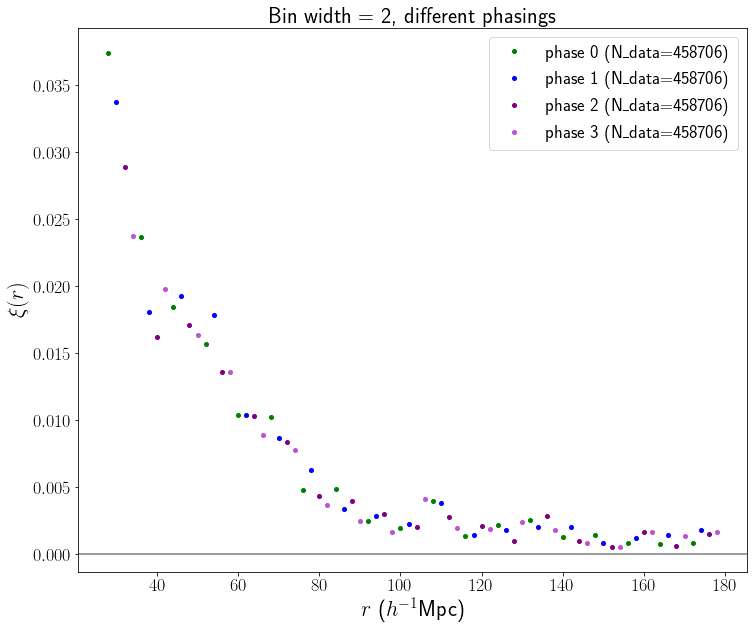

In [20]:
colors = ['green', 'blue', 'purple', 'mediumorchid']
plt.figure(figsize=(12,10))
plt.title('Bin width = 2, different phasings', fontsize=22)
for pp in range(int(bin_size/phase_size)):
    rmin_p = rmin + phase_size*pp
    rmax_p = rmax + phase_size*pp
    
    r_edges = np.arange(rmin_p, rmax_p+bin_size, bin_size)
    print(r_edges)
    r_avg = 0.5 * (r_edges[1:] + r_edges[:-1])
    
    title = f'phase {pp}'
    n_data = np.sum(idx_data_G[gg])
    plt.plot(r_avg, xis_phase[pp], marker='o', markersize=4, ls='None', color=colors[pp], 
             label=title+f' (N_data={n_data})')

plt.xlabel(r'$r$ ($h^{-1}$Mpc)')
plt.ylabel(r'$\xi(r)$')
plt.axhline(0, color='grey')
plt.legend()